# 06 - HIRT Borehole Survey

End-to-end simulation of a HIRT dual-probe borehole survey. This is the
HIRT equivalent of NB02's Pathfinder survey, covering:

1. Scenario and HIRT config inspection
2. Site layout and probe geometry
3. FDEM measurement generation and simulation
4. ERT measurement generation and simulation
5. Combined detection analysis
6. CSV export and round-trip verification
7. One-function `run_hirt_survey()` entry point

**Scenario:** `swamp-crash-site.json`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import tempfile

from geosim.scenarios.loader import load_scenario
from geosim.sensors.hirt import (
    HIRTSurveyConfig, probe_to_global,
    generate_fdem_measurements, generate_ert_measurements,
    simulate_fdem, simulate_ert,
    export_fdem_csv, export_ert_csv,
    run_hirt_survey,
)
from geosim.em.coil import hirt_default_coils
from geosim.noise.models import hirt_fdem_noise_model

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

## 1. Load Scenario and Inspect HIRT Configuration

In [2]:
scenario = load_scenario(Path('..') / 'scenarios' / 'swamp-crash-site.json')
hirt = scenario.hirt_config

print(f'Scenario: {scenario.name}')
print(f'Description: {scenario.description}')
print(f'Terrain: {scenario.terrain.x_extent[1]}m x {scenario.terrain.y_extent[1]}m')
print(f'Objects: {len(scenario.objects)}')
print(f'Anomaly zones: {len(scenario.anomaly_zones)}')
print()
print('HIRT Config:')
print(f'  Probes: {len(hirt.probes)}')
print(f'  Frequencies: {hirt.frequencies} Hz')
print(f'  Injection current: {hirt.injection_current*1000:.0f} mA')
print(f'  Array type: {hirt.array_type}')
print()
for i, probe in enumerate(hirt.probes):
    print(f'  Probe {i}: pos={probe.position}, length={probe.length}m, '
          f'{len(probe.ring_depths)} rings, {len(probe.coil_depths)} coils')

Scenario: Swamp/Marsh Crash Site
Description: Aircraft crash site in waterlogged marsh terrain. High water table and conductive saturated soils make this the most challenging EM/ERT scenario. Based on HIRT's 4th validation scenario.
Terrain: 25.0m x 25.0m
Objects: 5
Anomaly zones: 2

HIRT Config:
  Probes: 2
  Frequencies: [1000.0, 5000.0, 25000.0] Hz
  Injection current: 10 mA
  Array type: crosshole

  Probe 0: pos=[11.0, 12.5, 0.0], length=1.0m, 8 rings, 6 coils
  Probe 1: pos=[14.0, 12.5, 0.0], length=1.0m, 8 rings, 6 coils


In [3]:
# Inspect EM sources and resistivity model
print('EM Sources (objects with conductivity > 0):')
for src in scenario.em_sources:
    print(f'  {src["name"]:<30} r={src["radius"]*100:.0f}cm  '
          f'sigma={src["conductivity"]:.0e} S/m  pos={src["position"]}')

print()
res_model = scenario.resistivity_model
print('Resistivity model:')
for i, rho in enumerate(res_model['resistivities']):
    h = res_model['thicknesses'][i] if i < len(res_model['thicknesses']) else 'halfspace'
    print(f'  Layer {i+1}: rho={rho:.1f} Ohm-m, thickness={h}')

print()
cond_model = scenario.build_conductivity_model()
print(f'Conductivity model: {len(cond_model["background"])} background layers, '
      f'{len(cond_model["anomalies"])} anomaly zones')

EM Sources (objects with conductivity > 0):
  Engine block (submerged)       r=20cm  sigma=5e+06 S/m  pos=[12.  13.  -2.5]
  Propeller hub                  r=12cm  sigma=4e+06 S/m  pos=[10.  14.  -1.5]
  Wing root fitting              r=7cm  sigma=3e+06 S/m  pos=[15. 11. -1.]
  Ammunition box cluster         r=5cm  sigma=2e+06 S/m  pos=[13.5 16.  -0.8]
  Control cable bundle           r=3cm  sigma=1e+06 S/m  pos=[11.  10.  -0.6]

Resistivity model:
  Layer 1: rho=6.7 Ohm-m, thickness=0.5
  Layer 2: rho=3.3 Ohm-m, thickness=2.5
  Layer 3: rho=12.5 Ohm-m, thickness=halfspace

Conductivity model: 3 background layers, 2 anomaly zones


## 2. Site Layout

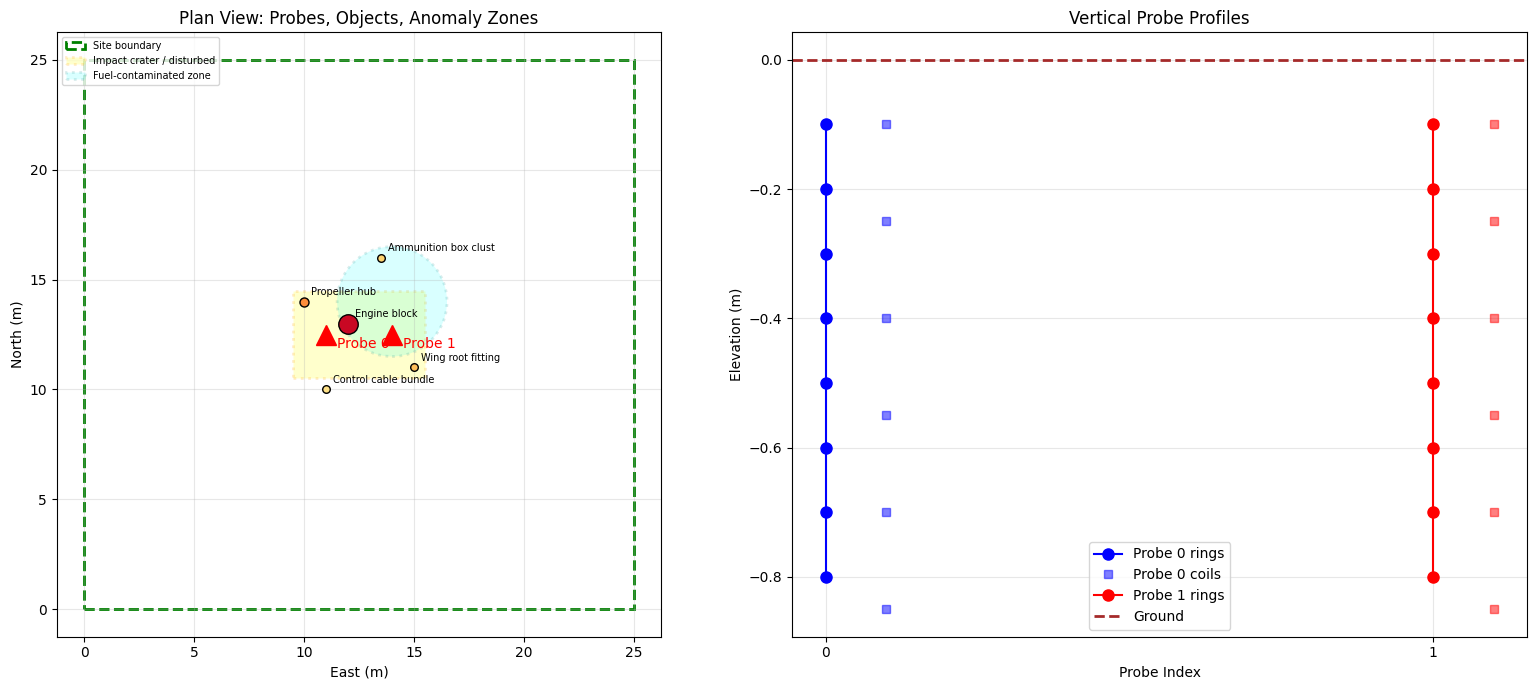

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plan view
x_ext = scenario.terrain.x_extent
y_ext = scenario.terrain.y_extent
ax1.add_patch(plt.Rectangle(
    (x_ext[0], y_ext[0]), x_ext[1]-x_ext[0], y_ext[1]-y_ext[0],
    fill=False, edgecolor='green', linewidth=2, linestyle='--', label='Site boundary'
))

# Objects
for obj in scenario.objects:
    m_mag = np.linalg.norm(obj.moment) if obj.moment is not None else 0
    size = max(30, m_mag * 50)
    ax1.scatter(obj.position[0], obj.position[1], s=size,
               c=obj.position[2], cmap='YlOrRd_r', vmin=-3, vmax=0,
               edgecolors='black', linewidth=1, zorder=5)
    ax1.annotate(obj.name.split('(')[0].strip()[:20],
                 (obj.position[0], obj.position[1]),
                 xytext=(5, 5), textcoords='offset points', fontsize=7)

# Anomaly zones
for az in scenario.anomaly_zones:
    if az.shape == 'box':
        cx, cy = az.center[0], az.center[1]
        w = az.dimensions.get('width', 2)
        l = az.dimensions.get('length', 2)
        ax1.add_patch(plt.Rectangle(
            (cx - l/2, cy - w/2), l, w,
            fill=True, facecolor='yellow', alpha=0.2, edgecolor='orange',
            linewidth=2, linestyle=':', label=az.name[:25]
        ))
    elif az.shape == 'cylinder':
        circle = plt.Circle((az.center[0], az.center[1]),
                           az.dimensions.get('radius', 1),
                           fill=True, facecolor='cyan', alpha=0.15,
                           edgecolor='teal', linewidth=2, linestyle=':', label=az.name[:25])
        ax1.add_patch(circle)

# Probes
for i, probe in enumerate(hirt.probes):
    ax1.plot(probe.position[0], probe.position[1], 'r^', markersize=15, zorder=10)
    ax1.annotate(f'Probe {i}', (probe.position[0], probe.position[1]),
                 xytext=(8, -10), textcoords='offset points', fontsize=10, color='red')

ax1.set_xlabel('East (m)')
ax1.set_ylabel('North (m)')
ax1.set_title('Plan View: Probes, Objects, Anomaly Zones')
ax1.set_aspect('equal')
ax1.legend(loc='upper left', fontsize=7)
ax1.grid(True, alpha=0.3)

# Vertical probe profiles
for i, probe in enumerate(hirt.probes):
    depths = np.array(probe.ring_depths)
    global_positions = probe_to_global(depths, probe)

    color = 'blue' if i == 0 else 'red'
    ax2.plot(np.full(len(depths), i), global_positions[:, 2], 'o-',
             color=color, markersize=8, label=f'Probe {i} rings')

    # Coil positions
    coil_depths = np.array(probe.coil_depths)
    coil_global = probe_to_global(coil_depths, probe)
    ax2.plot(np.full(len(coil_depths), i) + 0.1, coil_global[:, 2], 's',
             color=color, markersize=6, alpha=0.5, label=f'Probe {i} coils' if i == 0 else '')

ax2.axhline(0, color='brown', lw=2, ls='--', label='Ground')
ax2.set_xlabel('Probe Index')
ax2.set_ylabel('Elevation (m)')
ax2.set_title('Vertical Probe Profiles')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xticks([0, 1])

plt.tight_layout()

## 3. FDEM Measurement Generation

Total FDEM measurements: 108
Frequencies: [1000.0, 5000.0, 25000.0]
TX coils: 3, RX coils: 3


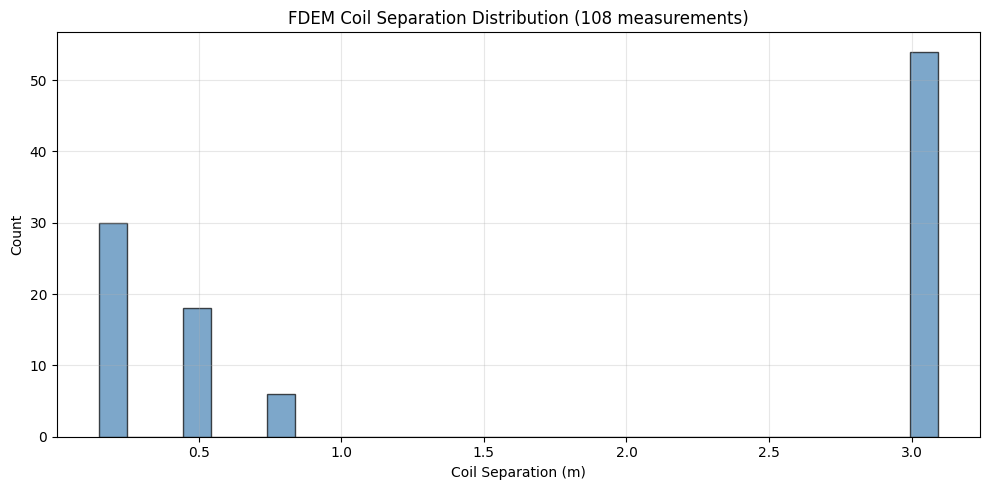

In [5]:
config = HIRTSurveyConfig(frequencies=hirt.frequencies)
coil_set = config.coil_set

fdem_meas = generate_fdem_measurements(hirt.probes, coil_set, config.frequencies)
print(f'Total FDEM measurements: {len(fdem_meas)}')
print(f'Frequencies: {config.frequencies}')
print(f'TX coils: {len(coil_set.transmitters)}, RX coils: {len(coil_set.receivers)}')

# Coil separation histogram
separations = [m.coil_separation for m in fdem_meas]

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(separations, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax.set_xlabel('Coil Separation (m)')
ax.set_ylabel('Count')
ax.set_title(f'FDEM Coil Separation Distribution ({len(fdem_meas)} measurements)')
ax.grid(True, alpha=0.3)

plt.tight_layout()

## 4. FDEM Simulation

In [6]:
# Build conductivity model from terrain layers
layers = scenario.terrain.layers
thicknesses = [abs(layers[i].z_top - layers[i].z_bottom) for i in range(len(layers)-1)]
conductivities = [layer.conductivity for layer in layers]
cond_model = {'thicknesses': thicknesses, 'conductivities': conductivities}

# Simulate clean and noisy
rng = np.random.default_rng(42)
fdem_clean = simulate_fdem(fdem_meas, cond_model, scenario.em_sources, config, add_noise=False)
fdem_noisy = simulate_fdem(fdem_meas, cond_model, scenario.em_sources, config, rng, add_noise=True)

# Convert to pandas DataFrame
df_clean = pd.DataFrame(fdem_clean)
df_noisy = pd.DataFrame(fdem_noisy)

print(f'FDEM data shape: {df_clean.shape}')
print()
print('Statistics by frequency (clean):')
print(df_clean.groupby('frequency')[['response_real', 'response_imag', 'skin_depth']].describe().round(4))

FDEM data shape: (108, 9)

Statistics by frequency (clean):
          response_real                                                 \
                  count    mean     std     min    25%     50%     75%   
frequency                                                                
1000.0             36.0  0.1875  0.0137  0.1668  0.167  0.1937  0.1941   
5000.0             36.0  0.1875  0.0137  0.1668  0.167  0.1937  0.1941   
25000.0            36.0  0.1875  0.0137  0.1668  0.167  0.1937  0.1941   

                  response_imag       ...           skin_depth                \
              max         count mean  ...  75%  max      count     mean  std   
frequency                             ...                                      
1000.0     0.2129          36.0  0.0  ...  0.0  0.0       36.0  37.8654  0.0   
5000.0     0.2129          36.0  0.0  ...  0.0  0.0       36.0  16.9339  0.0   
25000.0    0.2129          36.0  0.0  ...  0.0  0.0       36.0   7.5731  0.0   

              

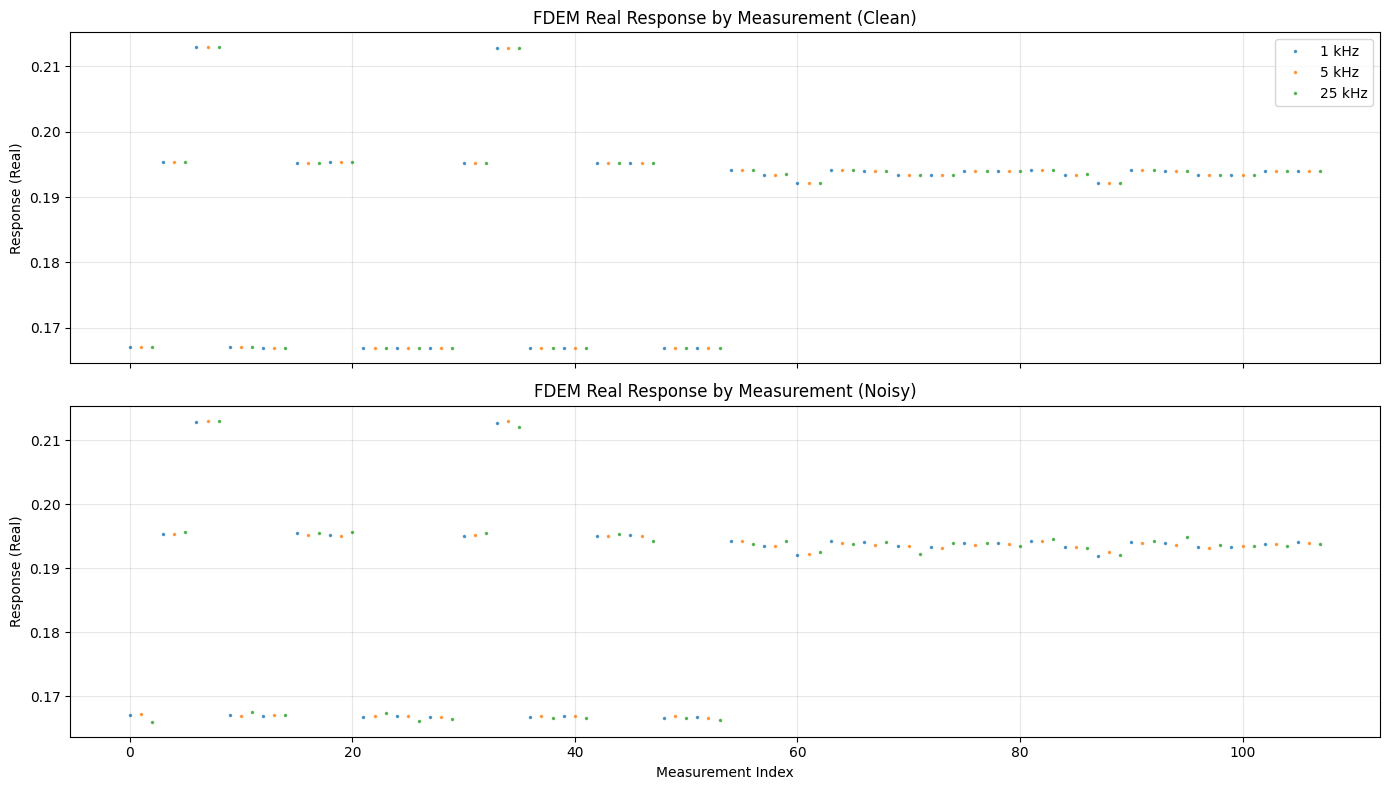

In [7]:
# FDEM response vs measurement index, colored by frequency
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

for freq in config.frequencies:
    mask = df_clean['frequency'] == freq
    ax1.plot(df_clean.loc[mask, 'measurement_id'],
             df_clean.loc[mask, 'response_real'], '.', markersize=3,
             label=f'{freq/1000:.0f} kHz', alpha=0.7)
    ax2.plot(df_noisy.loc[mask, 'measurement_id'],
             df_noisy.loc[mask, 'response_real'], '.', markersize=3,
             alpha=0.7)

ax1.set_ylabel('Response (Real)')
ax1.set_title('FDEM Real Response by Measurement (Clean)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('Measurement Index')
ax2.set_ylabel('Response (Real)')
ax2.set_title('FDEM Real Response by Measurement (Noisy)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()

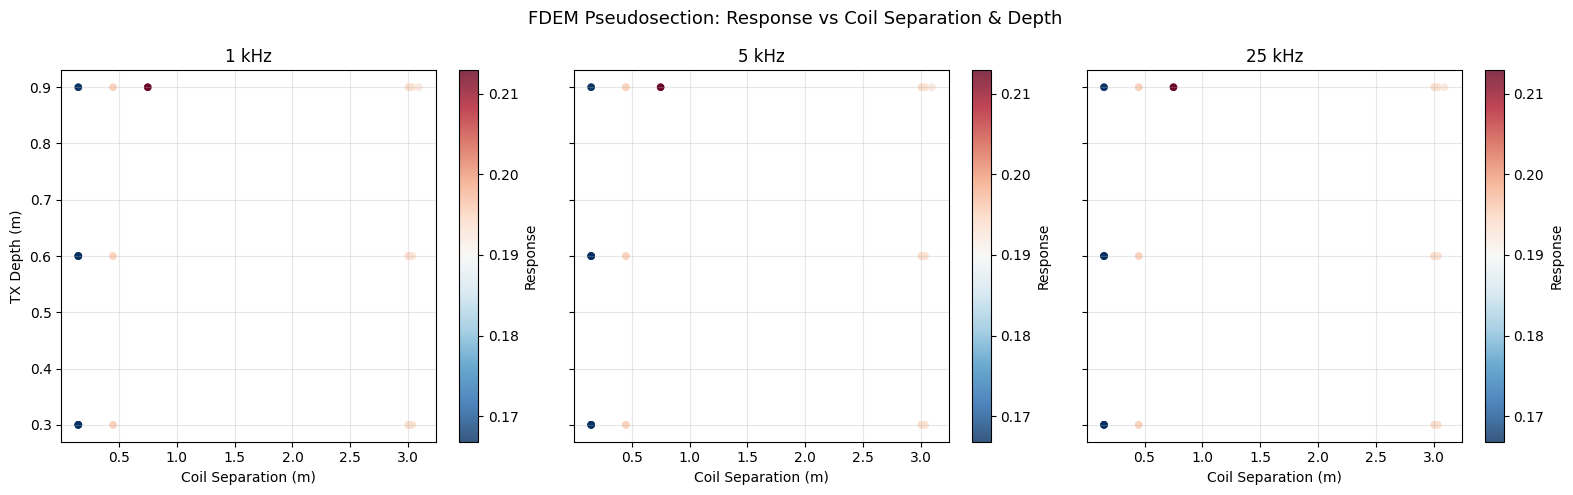

In [8]:
# Pseudosection: response vs coil separation
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for ax, freq in zip(axes, config.frequencies):
    mask = df_clean['frequency'] == freq
    sc = ax.scatter(
        df_clean.loc[mask, 'coil_separation'],
        df_clean.loc[mask, 'tx_depth'],
        c=df_clean.loc[mask, 'response_real'],
        cmap='RdBu_r', s=20, alpha=0.8,
    )
    ax.set_xlabel('Coil Separation (m)')
    ax.set_title(f'{freq/1000:.0f} kHz')
    ax.grid(True, alpha=0.3)
    plt.colorbar(sc, ax=ax, label='Response')

axes[0].set_ylabel('TX Depth (m)')
fig.suptitle('FDEM Pseudosection: Response vs Coil Separation & Depth', fontsize=13)

plt.tight_layout()

## 5. ERT Measurement Generation and Simulation

In [9]:
ert_meas = generate_ert_measurements(hirt.probes, config.electrode_array)
print(f'Total ERT measurements: {len(ert_meas)}')
print(f'Example labels: C1={ert_meas[0].c1_label}, C2={ert_meas[0].c2_label}, '
      f'P1={ert_meas[0].p1_label}, P2={ert_meas[0].p2_label}')

# Simulate
rng_ert = np.random.default_rng(42)
ert_clean = simulate_ert(ert_meas, scenario.resistivity_model, config, add_noise=False)
ert_noisy = simulate_ert(ert_meas, scenario.resistivity_model, config, rng_ert, add_noise=True)

df_ert_clean = pd.DataFrame(ert_clean)
df_ert_noisy = pd.DataFrame(ert_noisy)

print(f'\nApparent resistivity (clean): mean={df_ert_clean["apparent_resistivity"].mean():.2f}, '
      f'std={df_ert_clean["apparent_resistivity"].std():.2f} Ohm-m')

Total ERT measurements: 98
Example labels: C1=A1, C2=A2, P1=B1, P2=B2

Apparent resistivity (clean): mean=22.85, std=0.01 Ohm-m


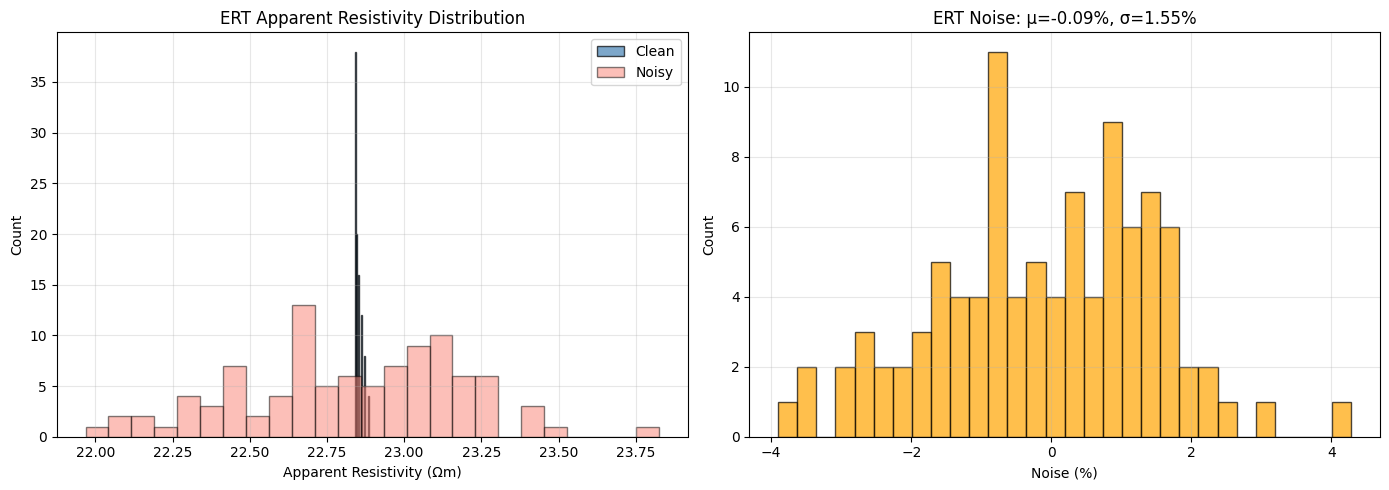

In [10]:
# Apparent resistivity histogram and noise comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(df_ert_clean['apparent_resistivity'], bins=25, color='steelblue',
         edgecolor='black', alpha=0.7, label='Clean')
ax1.hist(df_ert_noisy['apparent_resistivity'], bins=25, color='salmon',
         edgecolor='black', alpha=0.5, label='Noisy')
ax1.set_xlabel('Apparent Resistivity (\u03a9m)')
ax1.set_ylabel('Count')
ax1.set_title('ERT Apparent Resistivity Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Percent noise
clean_rho = np.array(ert_clean['apparent_resistivity'])
noisy_rho = np.array(ert_noisy['apparent_resistivity'])
pct_noise = (noisy_rho - clean_rho) / clean_rho * 100

ax2.hist(pct_noise, bins=30, color='orange', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Noise (%)')
ax2.set_ylabel('Count')
ax2.set_title(f'ERT Noise: \u03bc={np.mean(pct_noise):.2f}%, \u03c3={np.std(pct_noise):.2f}%')
ax2.grid(True, alpha=0.3)

plt.tight_layout()

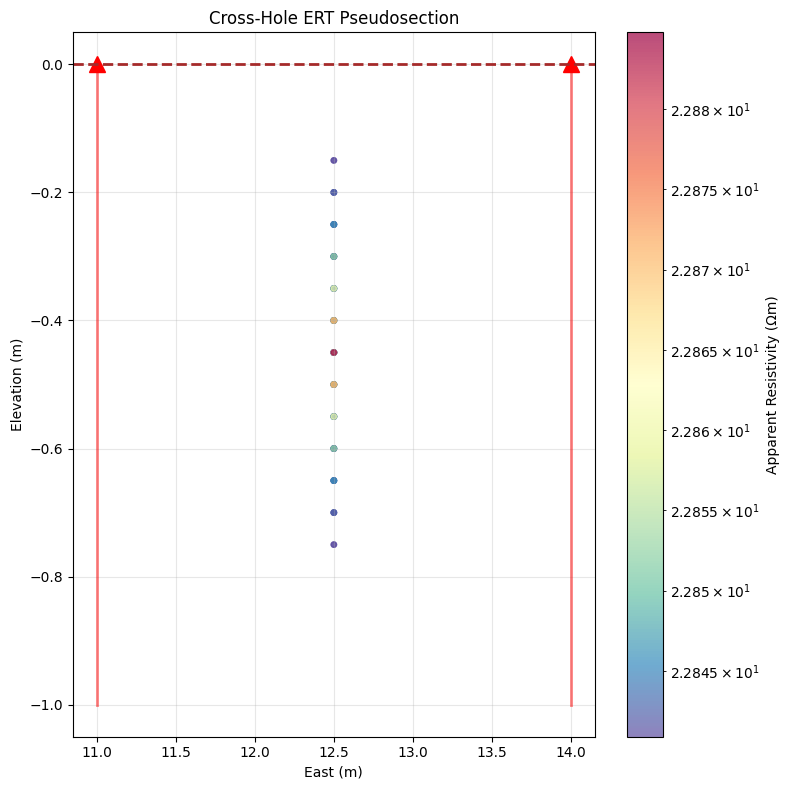

In [11]:
# ERT cross-hole pseudosection
# For each measurement, compute midpoint depth and horizontal position
mid_z = []
mid_x = []
for m in ert_meas:
    all_pos = np.array([m.c1_position, m.c2_position, m.p1_position, m.p2_position])
    mid_z.append(np.mean(all_pos[:, 2]))
    mid_x.append(np.mean(all_pos[:, 0]))

fig, ax = plt.subplots(figsize=(8, 8))
sc = ax.scatter(
    mid_x, mid_z,
    c=ert_clean['apparent_resistivity'],
    cmap='Spectral_r', s=15, alpha=0.7,
    norm=plt.matplotlib.colors.LogNorm(),
)
plt.colorbar(sc, ax=ax, label='Apparent Resistivity (\u03a9m)')

# Mark probe positions
for i, probe in enumerate(hirt.probes):
    ax.plot(probe.position[0], 0, 'r^', markersize=12)
    ax.plot([probe.position[0], probe.position[0]], [0, -probe.length],
            'r-', lw=2, alpha=0.5)

ax.axhline(0, color='brown', lw=2, ls='--')
ax.set_xlabel('East (m)')
ax.set_ylabel('Elevation (m)')
ax.set_title('Cross-Hole ERT Pseudosection')
ax.grid(True, alpha=0.3)

plt.tight_layout()

## 6. Combined Detection Analysis

Which objects are detectable by FDEM vs ERT? FDEM detects conductive targets
via secondary field response; ERT maps resistivity contrasts from anomaly zones.

In [12]:
from geosim.em.fdem import secondary_field_conductive_sphere

# FDEM detectability: compute max sphere response at closest probe
print(f'{"Object":<30} {"FDEM Response":>14} {"Mag Moment":>12} {"FDEM?":>8} {"Mag?":>8}')
print('-' * 76)

probe_positions = [np.array(p.position) for p in hirt.probes]

for obj in scenario.objects:
    # FDEM: max sphere response at closest probe midpoint
    max_resp = 0
    for pp in probe_positions:
        obs_pt = np.array([pp[0], pp[1], obj.position[2]])
        dist = np.linalg.norm(obj.position - obs_pt)
        if dist > obj.radius:
            resp = abs(secondary_field_conductive_sphere(
                obj.radius, obj.conductivity, 5000.0, dist
            ))
            max_resp = max(max_resp, resp)

    # Magnetic moment
    m_mag = np.linalg.norm(obj.moment) if obj.moment is not None else 0

    fdem_detect = 'YES' if max_resp > config.fdem_noise_floor * 3 else 'marginal' if max_resp > config.fdem_noise_floor else 'no'
    mag_detect = 'YES' if m_mag > 0.01 else 'marginal' if m_mag > 0.001 else 'no'

    print(f'{obj.name:<30} {max_resp:>14.6e} {m_mag:>12.4f} {fdem_detect:>8} {mag_detect:>8}')

Object                          FDEM Response   Mag Moment    FDEM?     Mag?
----------------------------------------------------------------------------
Engine block (submerged)         1.242065e-03       3.9248      YES      YES
Propeller hub                    6.268828e-05       0.8467       no      YES
Wing root fitting                1.191271e-05       0.1677       no      YES
Ammunition box cluster           5.404199e-07       0.0614       no      YES
Control cable bundle             2.684910e-07       0.0131       no      YES


## 7. CSV Export and Round-Trip Verification

In [13]:
with tempfile.TemporaryDirectory() as tmpdir:
    fdem_path = Path(tmpdir) / 'hirt_fdem.csv'
    ert_path = Path(tmpdir) / 'hirt_ert.csv'

    export_fdem_csv(fdem_noisy, fdem_path)
    export_ert_csv(ert_noisy, ert_path)

    print(f'FDEM CSV: {fdem_path.stat().st_size / 1024:.1f} KB')
    print(f'ERT CSV:  {ert_path.stat().st_size / 1024:.1f} KB')

    # Round-trip: read back and compare
    df_fdem_rt = pd.read_csv(fdem_path)
    df_ert_rt = pd.read_csv(ert_path)

    print(f'\nFDEM round-trip: {df_fdem_rt.shape[0]} rows, {df_fdem_rt.shape[1]} columns')
    print(f'ERT round-trip:  {df_ert_rt.shape[0]} rows, {df_ert_rt.shape[1]} columns')
    print(f'\nFDEM columns: {list(df_fdem_rt.columns)}')
    print(f'ERT columns:  {list(df_ert_rt.columns)}')

    # Verify values match
    fdem_match = np.allclose(
        df_fdem_rt['response_real'].values,
        fdem_noisy['response_real'],
        rtol=1e-6,
    )
    print(f'\nFDEM values match: {fdem_match}')

FDEM CSV: 12.1 KB
ERT CSV:  4.5 KB

FDEM round-trip: 108 rows, 9 columns
ERT round-trip:  98 rows, 7 columns

FDEM columns: ['measurement_id', 'probe_pair', 'tx_depth', 'rx_depth', 'coil_separation', 'frequency', 'response_real', 'response_imag', 'skin_depth']
ERT columns:  ['measurement_id', 'c1_electrode', 'c2_electrode', 'p1_electrode', 'p2_electrode', 'geometric_factor', 'apparent_resistivity']

FDEM values match: True


## 8. One-Function Entry Point: `run_hirt_survey()`

In [14]:
with tempfile.TemporaryDirectory() as tmpdir:
    scenario_path = Path('..') / 'scenarios' / 'swamp-crash-site.json'

    result = run_hirt_survey(
        scenario_path,
        output_dir=tmpdir,
        fdem_enabled=True,
        ert_enabled=True,
        add_noise=True,
        seed=42,
    )

    print('run_hirt_survey() returned:')
    print(f'  FDEM: {len(result["fdem"]["measurement_id"])} measurements')
    print(f'  ERT:  {len(result["ert"]["measurement_id"])} measurements')
    print(f'  FDEM CSV: {result["fdem_csv"]}')
    print(f'  ERT CSV:  {result["ert_csv"]}')

    # Verify it matches step-by-step
    auto_fdem_real = np.array(result['fdem']['response_real'])
    step_fdem_real = np.array(fdem_noisy['response_real'])
    print(f'\nFDEM step-by-step vs run_hirt_survey():')
    print(f'  Same length: {len(auto_fdem_real) == len(step_fdem_real)}')
    print(f'  (Values may differ due to different RNG sequences)')

run_hirt_survey() returned:
  FDEM: 108 measurements
  ERT:  98 measurements
  FDEM CSV: /tmp/tmpexhp9bps/hirt_fdem.csv
  ERT CSV:  /tmp/tmpexhp9bps/hirt_ert.csv

FDEM step-by-step vs run_hirt_survey():
  Same length: True
  (Values may differ due to different RNG sequences)


## 9. 3D Visualization

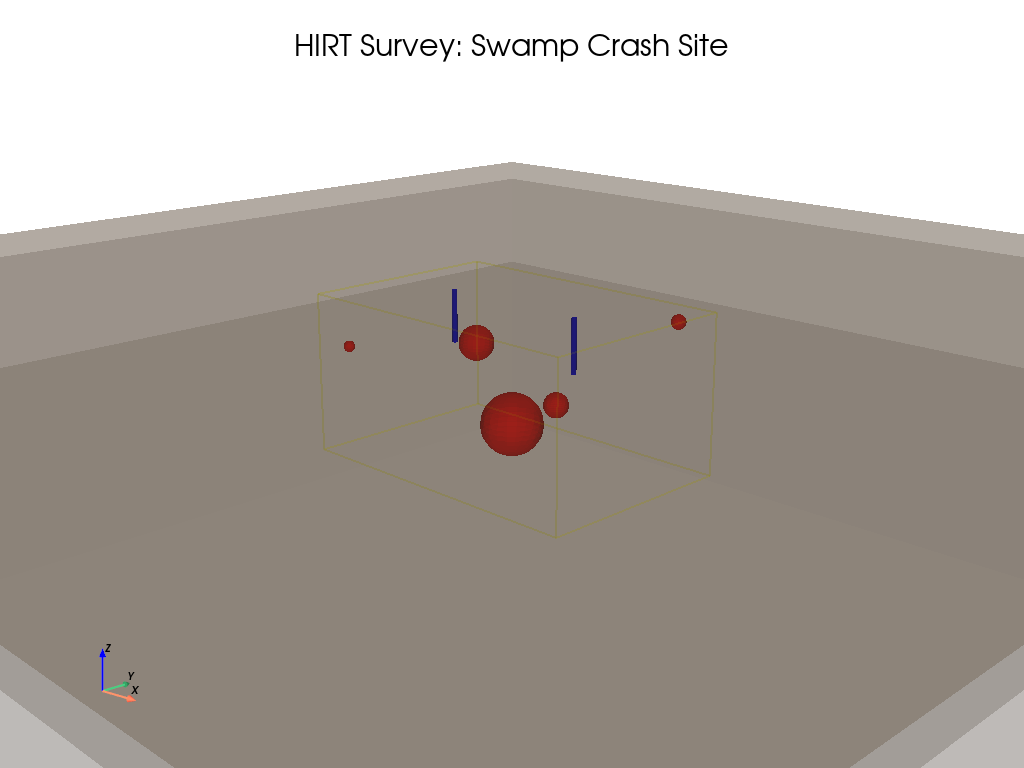

In [15]:
import pyvista as pv
from geosim.viz.scenes import create_survey_scene
from geosim.viz.terrain import create_terrain_mesh, create_soil_layers
from geosim.viz.objects import create_buried_objects

pv.set_jupyter_backend('static')

plotter = pv.Plotter(off_screen=True)
plotter.set_background('white')

# Terrain
terrain = create_terrain_mesh(scenario)
plotter.add_mesh(terrain, color='#8B7355', opacity=0.3)

# Soil layers
layer_colors = ['#2E1A0E', '#4A3E36', '#6B6054']
layers_meshes = create_soil_layers(scenario)
for i, lm in enumerate(layers_meshes):
    plotter.add_mesh(lm, opacity=0.1, color=layer_colors[i % len(layer_colors)])

# Buried objects
objects = create_buried_objects(scenario, scale_factor=3.0)
for mesh, props in objects:
    plotter.add_mesh(mesh, color='red', opacity=0.7)

# Probe cylinders
for i, probe in enumerate(hirt.probes):
    p = probe.position
    cyl = pv.Cylinder(
        center=[p[0], p[1], -probe.length/2],
        direction=[0, 0, 1],
        radius=0.05,
        height=probe.length,
    )
    plotter.add_mesh(cyl, color='blue', opacity=0.8)

# Anomaly zones
for az in scenario.anomaly_zones:
    if az.shape == 'box':
        c = az.center
        d = az.dimensions
        box = pv.Box(bounds=(
            c[0]-d['length']/2, c[0]+d['length']/2,
            c[1]-d['width']/2, c[1]+d['width']/2,
            c[2]-d['depth']/2, c[2]+d['depth']/2,
        ))
        plotter.add_mesh(box, color='yellow', opacity=0.15, style='wireframe', line_width=2)

x_ext = scenario.terrain.x_extent
y_ext = scenario.terrain.y_extent
plotter.camera_position = [
    (x_ext[1]*1.2, y_ext[0]-5, 6),
    ((x_ext[0]+x_ext[1])/2, (y_ext[0]+y_ext[1])/2, -1.5),
    (0, 0, 1),
]
plotter.add_axes()
plotter.add_title('HIRT Survey: Swamp Crash Site', font_size=12)
plotter.show()

## Key Takeaways

1. **HIRT surveys are borehole-based** — probes remain stationary, measurements are over coil/electrode pairs
2. **FDEM generates 108 measurements** (3 TX x 3 RX x 3 freqs x 2 probes, intra + cross)
3. **ERT generates 98 quadrupoles** (7 adjacent pairs per borehole, both directions)
4. **FDEM is sensitive to conductive targets** (metal objects) — response scales with radius\u00b3
5. **ERT maps resistivity contrasts** — effective for anomaly zone delineation in conductive terrain
6. **CSV export** produces standard tabular formats for external analysis
7. **`run_hirt_survey()`** chains the entire pipeline in one call

Next: [07-forensic-and-uxo.ipynb](07-forensic-and-uxo.ipynb) — Forensic grave search and UXO clearance scenarios